# Flax-Pilot VAE MNIST Notebook

This notebook demonstrates the usage of flax-pilot to train a VAE. The workflow uses distributed training using jax.pmap on Kaggle GPU

**Use TensorFlow-cpu instead of TensorFlow to avoid any issues between TensorFlow & Jax.**

In [1]:
!pip install -q tensorflow-cpu

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.
tensorflow 2.15.0 requires ml-dtypes~=0.2.0, but you have ml-dtypes 0.3.2 which is incompatible.
tensorflow 2.15.0 requires tensorboard<2.16,>=2.15, but you have tensorboard 2.16.2 which is incompatible.


In [2]:
!pip install -q mergedeep

In [3]:
import jax
import optax
import tensorflow as tf
import flax.linen as nn
import jax.numpy as jnp
import jax.random as jr

In [4]:
import jax, flax, orbax.checkpoint
jax.__version__, flax.__version__, orbax.checkpoint.__version__

('0.4.26', '0.8.4', '0.5.15')

### Create a simple VAE Model.

*Note: The main model must always have a '**deterministic**' param to handle layers like dropout. Not adding '**deterministic**' param will lead to error as flax-pilot always expects this param, irrespective of whether the model has any stochastic layers or not.*

In [5]:
class Encoder(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.relu(nn.Conv(features=32, kernel_size=(3, 3), strides=2, padding='SAME')(x))
        x = nn.relu(nn.Conv(features=64, kernel_size=(3, 3), strides=2, padding='SAME')(x))
        x = x.reshape(x.shape[0], -1)
        x = nn.relu(nn.Dense(16)(x))
        mean = nn.Dense(2)(x)
        logvar = nn.Dense(2)(x)
        return mean, logvar

    
class Decoder(nn.Module):    
    @nn.compact
    def __call__(self, z):
        y = nn.relu(nn.Dense(49*64)(z))
        y = y.reshape(y.shape[0], 7, 7, 64)
        y = nn.relu(nn.ConvTranspose(features=64, kernel_size=(3, 3), strides=2, padding='SAME')(y))
        y = nn.relu(nn.ConvTranspose(features=32, kernel_size=(3, 3), strides=2, padding='SAME')(y))
        y = nn.ConvTranspose(features=1, kernel_size=(3, 3), padding='SAME')(y)
        y = nn.sigmoid(y)
        return y
        
        
class VAE(nn.Module):
    def setup(self,):
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    
    # Must have 'deterministic param'.
    @nn.compact
    def __call__(self, x, deterministic):
        mean, logvar = self.encode(x)
        z = self.reparam_trick(mean, logvar)
        y = self.decode(z)
        return (mean, logvar), y
        
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, x):
        return self.decoder(x)
    
    def reparam_trick(self, mean, logvar):
        e = jr.normal(self.make_rng('normal'), mean.shape)
        return mean + jnp.exp(0.5*logvar)*e


### Create tf.data.Dataset
Distributed training in this notebook is performed using jax.pmap. jax.pmap expects the first dimension of its input tensor as the number of devices in parallel.<br>
<br> 
So Input tensor must have shape **(NO_OF_DEVICES, LOCAL_BATCH_SIZE, ...)**<br>
MNIST Images have shape : **(28, 28, 1)**<br>
In this case, input shape will be : **(2, 128, 28, 28, 1)**. So, we have 2 devices, each device will receive a batch of shape **(128, 28, 28, 1)**.

GLOBAL_BATCH_SIZE = LOCAL_BATCH_SIZE * NO_OF_DEVICES<br>
In this case, GLOBAL_BATCH_SIZE = 256

In [6]:
(x_train, y_train), (x_val, y_val) = tf.keras.datasets.mnist.load_data()

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.shuffle(256).batch(128, True)
train_ds = train_ds.map(lambda x, y: (tf.expand_dims(x, -1)/255), num_parallel_calls=tf.data.AUTOTUNE)

# Second batching for distributing with pmap.
train_ds = train_ds.batch(2, True)
train_ds = train_ds.repeat().as_numpy_iterator()

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_ds = val_ds.shuffle(256).batch(128, True)
val_ds = val_ds.map(lambda x, y: (tf.expand_dims(x, -1)/255), num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(2, True)
val_ds = val_ds.repeat().as_numpy_iterator()

train_ds, val_ds

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


(NumpyIterator(iterator=<tensorflow.python.data.ops.iterator_ops.OwnedIterator object at 0x7f5b07bce950>),
 NumpyIterator(iterator=<tensorflow.python.data.ops.iterator_ops.OwnedIterator object at 0x7f5aaf0721d0>))

### Loss Function

#### Inputs to the loss function

##### The `loss_fn` will always receive these six specific inputs, described as follows:

1. **params**:
   - **Description**: The model's parameters.
   - **Obtained by**: Using the `init` method of `flax.linen.Module`.
   - **Example**: `params = model.init(prng_key, input_shape)`.



2. **apply**:
   - **Description**: The `apply` method from `flax.linen.Module`, used to call other methods within the module.



3. **sample**:
   - **Description**: The input data to the model.


4. **deterministic**:
   - **Description**: Indicates whether to enable deterministic behavior in layers (similar to the `training` parameter in Keras).
   - **Usage**: 
     - Set to `True` during validation (`val_step`), where dropout is disabled.
     - Set to `False` during training (`train_step`).



5. **global_key**:
   - **Description**: A PRNGKey used to seed random variables, important for dropout and other random operations within the model.
   - **Management**: 
     - Updated using `jax.fold_in` within the `train_step` and `val_step` functions to ensure a unique key for each step.
     - When flax model requires multliple keys in its forward pass, the global prng key received here can be splitted into multliple prng keys using `jax.random.split`. These splits can be represented as a dict where keys of the dict are the `rng_name` used from within the model using `self.make_rng(rng_name)` and value as the prng key itself.
     - From within the model, prng keys can be accessed by `self.make_rng(rng_name)`.
     
     
    
6. **step**:
   - **Description**: Represents the current iteration or step number of the optimizer during training.
   - **Usage**: Can be used to weigh losses based on the current number of iterations. For example, it allows implementing techniques like annealing the KL divergence weight in a variational autoencoder or any other time-dependent adjustments during training.
   - **Management**:
     - Passed directly to the `loss_fn` within the `train_step` and `val_step` functions.
     - It is incremented at each iteration of the training loop.
     - Enables dynamic adjustments of the loss function or other training parameters as training progresses, offering more fine-grained control over the training process.


### Note:
- All these six parameters are crucial for training and must not be removed or replaced.
- Their names can be changed, but their order and functionality must remain the same.



This structure ensures that the `loss_fn` receives all necessary inputs in a consistent manner, facilitating proper model training and evaluation.

#### Outputs from the loss function

The function must return two elements:

1. **Scalar loss**:
   - **Description**: The value which should be minimized.
   - **Details**: This scalar is minimized with respect to the first parameter of the function, `params`.



2. **loss_metric_values_dict**:
   - **Description**: A dictionary that must always contain two keys, **'mt'** (metric tracker) and **'lt'** (loss tracker).
   - **Structure**:
     - Each of these parent keys must hold a child dictionary as its value, representing different metric and loss trackers.
     - The child dictionary's key names can be any string but must match with the tracker instances dictionary (explained in later cells).
     - The child dictionary's values must be the values being tracked.
   - **Details**:
     - For losses, the loss tracker is used to track the losses, so the child dictionaries of **'lt'** must have scalar loss as their values.
     - For classification metrics like Accuracy or F1Score, the child dictionary of **'mt'** will expect a tuple of `(y_true, y_pred)` as its value or a dictionary like `{'true': true, 'pred': pred}` as its value.
     - These values of child dict are passed to the `update` function of tracker instances. Check out `trackers.py` to understand the expected inputs of each tracker's update function.

In [7]:
def loss_fn(params, apply, sample, deterministic, global_key, step):
    x = sample
    (mean, logvar), y = apply(params, x, deterministic=deterministic, rngs={'normal': global_key})
    
    recons_loss = -(x*jnp.log(y+0.00001) + (1-x)*jnp.log(1-y+0.00001)).sum(axis=(1, 2)).mean()
    kl_loss = (-0.5 * (1 + logvar - jnp.square(mean) - jnp.exp(logvar))).sum(axis=(1, )).mean()
    loss = recons_loss + kl_loss
    loss_metric_values_dict = { 
        'lt': {'kl_loss': kl_loss.mean(), 'recons_loss': recons_loss.mean()},
        'mt': dict()
        }
    return loss, loss_metric_values_dict


### Access to the modules

In [8]:
import os
os.listdir("/kaggle/input/fpilot")

['trackers', 'checkpoints', 'training']

In [9]:
import glob, sys
sys.path.append("/kaggle/input")

### Creating tracker functions

Trackers are represented in a dictionary, with keys **'mt'** (metric tracker) and **'lt'** (loss tracker) being mandatory. Each of these keys must have a child dictionary as its value. The child dictionary's key names must match the child key names in `loss_metric_values_dict`. The value of the child dictionaries must be tracker instances.


In [12]:
import fpilot.trackers.basic_trackers as tr

trackers = {
        'lt': {'kl_loss': tr.Mean(), 'recons_loss': tr.Mean()},
        'mt':{}
}

### Trainer

The `Trainer` instance takes in five parameters:

1. **flax_model**:
   - **Description**: A `flax.linen.Module` instance.



2. **input_shape**:
   - **Description**: Shapes of input tensors passed to the model.
   - **Type**: A dictionary where the key is the parameter name of the model's `__call__` method and the value is the shape of the tensor.



3. **optimizer**:
   - **Description**: 
     - In single-objective training: It must be a single Optax optimizer. This optimizer is applied uniformly to all model parameters to minimize the loss function.
     - In multi-objective training (e.g., GANs): It must be a dictionary of optimizers. The keys of this dictionary correspond to the parameter's key  in the Flax `TrainState.params` that need to be optimized, and the values are the respective Optax optimizers for those parameters. This allows different sets of parameters to be optimized with different strategies.



4. **loss_metric_fn**:
   - **Description**: The loss function as explained above.



5. **trackers**:
   - **Description**: A dictionary of trackers as explained in the previous cell.

In [22]:
from fpilot.training.trainer import Trainer

trainer = Trainer(VAE(), {'x': (1, 28, 28, 1)}, optax.adam(0.001), loss_fn, trackers)

Check the docstring of **Trainer.train** for explaination 

In [15]:
trainer.train(30, train_ds, val_ds, 60000//256, 10000//256, '/kaggle/working/pilot-examples/vae_v4', 3)

Epoch 1: 100%|██████████| 234/234 [00:07<00:00, 32.17it/s] 


Train:  kl_loss: 4.472439, recons_loss: 230.04044, time: 7.278316020965576
Val:  kl_loss: 3.8327792, recons_loss: 200.38925, time: 1.609255075454712
State saved..


Epoch 2: 100%|██████████| 234/234 [00:01<00:00, 176.79it/s]


Train:  kl_loss: 3.8415704, recons_loss: 194.29297, time: 1.3261330127716064
Val:  kl_loss: 4.623519, recons_loss: 187.46286, time: 0.07249951362609863
State saved..


Epoch 3: 100%|██████████| 234/234 [00:01<00:00, 180.14it/s]


Train:  kl_loss: 5.223154, recons_loss: 177.54782, time: 1.3017780780792236
Val:  kl_loss: 5.782391, recons_loss: 170.93488, time: 0.07205486297607422
State saved..


Epoch 4: 100%|██████████| 234/234 [00:01<00:00, 178.85it/s]


Train:  kl_loss: 5.5094213, recons_loss: 167.93152, time: 1.3113036155700684
Val:  kl_loss: 5.5853624, recons_loss: 165.83209, time: 0.0745999813079834
State saved..


Epoch 5: 100%|██████████| 234/234 [00:01<00:00, 179.90it/s]


Train:  kl_loss: 5.6656604, recons_loss: 163.97665, time: 1.3035008907318115
Val:  kl_loss: 5.808654, recons_loss: 163.09128, time: 0.06995177268981934
State saved..


Epoch 6: 100%|██████████| 234/234 [00:01<00:00, 179.67it/s]


Train:  kl_loss: 5.837135, recons_loss: 161.16203, time: 1.306051254272461
Val:  kl_loss: 5.9716063, recons_loss: 160.37878, time: 0.06597471237182617
State saved..


Epoch 7: 100%|██████████| 234/234 [00:01<00:00, 179.48it/s]


Train:  kl_loss: 6.022992, recons_loss: 158.42761, time: 1.3067197799682617
Val:  kl_loss: 6.1616697, recons_loss: 158.09854, time: 0.07035589218139648
State saved..


Epoch 8: 100%|██████████| 234/234 [00:01<00:00, 179.38it/s]


Train:  kl_loss: 6.2000723, recons_loss: 156.16226, time: 1.307206392288208
Val:  kl_loss: 6.4141297, recons_loss: 157.34091, time: 0.0718691349029541
State saved..


Epoch 9: 100%|██████████| 234/234 [00:01<00:00, 179.37it/s]


Train:  kl_loss: 6.340522, recons_loss: 154.50436, time: 1.3074166774749756
Val:  kl_loss: 6.478882, recons_loss: 155.44019, time: 0.07249760627746582
State saved..


Epoch 10: 100%|██████████| 234/234 [00:01<00:00, 179.40it/s]


Train:  kl_loss: 6.4161916, recons_loss: 153.02188, time: 1.307178258895874
Val:  kl_loss: 6.422817, recons_loss: 153.6676, time: 0.0678262710571289
State saved..


Epoch 11: 100%|██████████| 234/234 [00:01<00:00, 178.28it/s]


Train:  kl_loss: 6.4918165, recons_loss: 151.82068, time: 1.3156278133392334
Val:  kl_loss: 6.518961, recons_loss: 152.10852, time: 0.07105040550231934
State saved..


Epoch 12: 100%|██████████| 234/234 [00:01<00:00, 178.97it/s]


Train:  kl_loss: 6.5534716, recons_loss: 150.97798, time: 1.310459852218628
Val:  kl_loss: 6.6855345, recons_loss: 151.58667, time: 0.07218551635742188
State saved..


Epoch 13: 100%|██████████| 234/234 [00:01<00:00, 178.32it/s]


Train:  kl_loss: 6.589575, recons_loss: 149.99918, time: 1.3149878978729248
Val:  kl_loss: 6.5851564, recons_loss: 151.23799, time: 0.07370924949645996
State saved..


Epoch 14: 100%|██████████| 234/234 [00:01<00:00, 178.07it/s]


Train:  kl_loss: 6.595643, recons_loss: 149.59744, time: 1.3167755603790283
Val:  kl_loss: 6.5215487, recons_loss: 149.8508, time: 0.07097792625427246
State saved..


Epoch 15: 100%|██████████| 234/234 [00:01<00:00, 178.34it/s]


Train:  kl_loss: 6.618601, recons_loss: 148.772, time: 1.3150215148925781
Val:  kl_loss: 6.622819, recons_loss: 149.41931, time: 0.0692589282989502
State saved..


Epoch 16: 100%|██████████| 234/234 [00:01<00:00, 177.32it/s]


Train:  kl_loss: 6.6409693, recons_loss: 148.34259, time: 1.32234525680542
Val:  kl_loss: 6.7717323, recons_loss: 150.07895, time: 0.06867122650146484
State saved..


Epoch 17: 100%|██████████| 234/234 [00:01<00:00, 177.49it/s]


Train:  kl_loss: 6.683149, recons_loss: 147.95978, time: 1.3211610317230225
Val:  kl_loss: 6.6676626, recons_loss: 149.32593, time: 0.07383513450622559
State saved..


Epoch 18: 100%|██████████| 234/234 [00:01<00:00, 177.95it/s]


Train:  kl_loss: 6.701246, recons_loss: 147.53299, time: 1.3175995349884033
Val:  kl_loss: 6.730364, recons_loss: 148.74506, time: 0.06963133811950684
State saved..


Epoch 19: 100%|██████████| 234/234 [00:01<00:00, 176.99it/s]


Train:  kl_loss: 6.713274, recons_loss: 147.14069, time: 1.3249330520629883
Val:  kl_loss: 6.6825657, recons_loss: 148.63715, time: 0.07208824157714844
State saved..


Epoch 20: 100%|██████████| 234/234 [00:01<00:00, 176.48it/s]


Train:  kl_loss: 6.723299, recons_loss: 146.88878, time: 1.3288404941558838
Val:  kl_loss: 6.6570024, recons_loss: 148.00381, time: 0.06786203384399414
State saved..


Epoch 21: 100%|██████████| 234/234 [00:01<00:00, 177.46it/s]


Train:  kl_loss: 6.731696, recons_loss: 146.58612, time: 1.3228082656860352
Val:  kl_loss: 6.7513113, recons_loss: 148.3277, time: 0.07127928733825684
State saved..


Epoch 22: 100%|██████████| 234/234 [00:01<00:00, 176.19it/s]


Train:  kl_loss: 6.7432795, recons_loss: 146.28062, time: 1.3307805061340332
Val:  kl_loss: 6.7528925, recons_loss: 148.20813, time: 0.06978917121887207
State saved..


Epoch 23: 100%|██████████| 234/234 [00:01<00:00, 176.12it/s]


Train:  kl_loss: 6.7554474, recons_loss: 146.06561, time: 1.3319799900054932
Val:  kl_loss: 6.7384214, recons_loss: 148.01389, time: 0.08291172981262207
State saved..


Epoch 24: 100%|██████████| 234/234 [00:01<00:00, 176.77it/s]


Train:  kl_loss: 6.7484636, recons_loss: 145.9363, time: 1.3264787197113037
Val:  kl_loss: 6.6177397, recons_loss: 148.4241, time: 0.06981396675109863
State saved..


Epoch 25: 100%|██████████| 234/234 [00:01<00:00, 175.94it/s]


Train:  kl_loss: 6.7691746, recons_loss: 145.68964, time: 1.3327908515930176
Val:  kl_loss: 6.7370834, recons_loss: 147.50739, time: 0.07182192802429199
State saved..


Epoch 26: 100%|██████████| 234/234 [00:01<00:00, 175.59it/s]


Train:  kl_loss: 6.7793064, recons_loss: 145.35867, time: 1.3353755474090576
Val:  kl_loss: 6.7562985, recons_loss: 147.26332, time: 0.0753626823425293
State saved..


Epoch 27: 100%|██████████| 234/234 [00:01<00:00, 175.91it/s]


Train:  kl_loss: 6.7873716, recons_loss: 145.26978, time: 1.3344497680664062
Val:  kl_loss: 6.6843677, recons_loss: 147.85545, time: 0.07618427276611328
State saved..


Epoch 28: 100%|██████████| 234/234 [00:01<00:00, 174.96it/s]


Train:  kl_loss: 6.8021336, recons_loss: 144.99934, time: 1.3405592441558838
Val:  kl_loss: 6.7220764, recons_loss: 147.19118, time: 0.06908988952636719
State saved..


Epoch 29: 100%|██████████| 234/234 [00:01<00:00, 174.88it/s]


Train:  kl_loss: 6.819153, recons_loss: 144.72992, time: 1.3408715724945068
Val:  kl_loss: 6.872183, recons_loss: 146.8078, time: 0.07405757904052734
State saved..


Epoch 30: 100%|██████████| 234/234 [00:01<00:00, 175.23it/s]


Train:  kl_loss: 6.8093195, recons_loss: 144.69662, time: 1.3386619091033936
Val:  kl_loss: 6.722869, recons_loss: 147.12486, time: 0.06958651542663574
State saved..


### Access any method of the model

To access methods of the model, one can call the Trainer instance. **Check docstring to understand its working.**
<br>The params are explained below

1. **rngs**:
   - **Description**: A dictionary where the values are `jax.random.PRNGKey` instances and the keys are the names used inside the model to reference these PRNGKeys.



2. **tensor_inputs**:
   - **Description**: The tensor inputs passed to the model's method you plan to call.
   - **Type**: A dictionary where each key is the name of a method parameter and each value is the corresponding tensor input.
   - **Note**: Tensor inputs must include a device dimension due to `jax.pmap` decoration, e.g., `(NO_OF_DEVICES, LOCAL_BATCH_SIZE, ...)`.



3. **method**:
   - **Description**: A string representing the method of the model you plan to call.
   - **Default**: The default value is the `__call__` method.



4. **kwargs**:
   - **Description**: Used to pass any static arguments to the method, such as the `deterministic` parameter.



Below are some examples.

*Note: Tensor inputs to methods are jax.pmap decorated so, inputs must include device dimension. For ex. __(NO_OF_DEVICES, LOCAL_BATCH_SIZE, ...)__*

#### Model call
The callable Trainer function accepts param '**method**' which represents the which method of the model to call. Default value is the **call** method.

In [16]:
sample = next(val_ds)[:, :8]

rngs = {'normal': jax.random.PRNGKey(53)}
tensor_inputs = {'x': sample}

output = trainer(rngs, tensor_inputs, deterministic=False)[1]

#### Model.decode

In [26]:
rand = jr.normal(jr.PRNGKey(13), (2, 8, 2))

rngs = {'normal': jax.random.PRNGKey(13)}
tensor_inputs = {'x': rand}

output = trainer(rngs, tensor_inputs, method='decode')

### Evaluate the model

In [18]:
trainer.evaluate(val_ds, 10000//256)

Val:  kl_loss: 6.719068, recons_loss: 147.15323, time: 0.0734403133392334


### Compute trackers

In [19]:
trainer.compute_trackers()

{'lt': {'kl_loss': Array([6.7150784, 6.7230577], dtype=float32),
  'recons_loss': Array([146.71928, 147.58717], dtype=float32)},
 'mt': {}}

### Save & Load checkpoints

In [20]:
# args: location to save checkpoint
trainer.save_state('/kaggle/working/pilot-examples/vae_v4_samplesave')

State saved..


In [25]:
# args: path to saved checkpoint folder, step number of checkpoint to restore
trainer.load_state('/kaggle/working/pilot-examples/vae_v4_samplesave', 7020)

### Visualize results

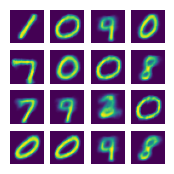

In [27]:
import matplotlib.pyplot as plt
plot_images = iter(output.reshape(16, 28, 28, 1))
fig, ax = plt.subplots(4, 4, figsize=(2, 2))

for x in range(4):
    for y in range(4):
        ax[x, y].imshow(next(plot_images))
        ax[x, y].axis('off')